In [3]:
%matplotlib inline
# Import libraries
from collections.abc import Iterator
from datetime import date, timedelta
from web3 import Web3

import boto3
import botocore
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import seaborn as sns
import string
import time
import warnings
import webbrowser

warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', None)

# Download Data

In [22]:
def iterate_dates(start_date: date, end_date: date) -> Iterator:
    '''Yields date in range of [start_date, end_date]

    Args:
        start_date: inclusive start date
        end_date: inclusive end date
    '''
    for n in range(int((end_date - start_date).days)+1):
        yield start_date + timedelta(n)

def convert_value_from_wei(transfers: pd.DataFrame, unit: string) -> pd.DataFrame:
    '''Convert value in WEI to unit for transfers
        where possible units are 'kwei', 'mwei', 'gwei', 'microether', 'milliether', 'ether'

    Args:
        transfers: dataframe you want to convert the value of
        unit: unit to convert to

    Returns:
        a new dataframe with converted value

    Raises:
        ValueError if unit is not valid
    '''
    if unit not in ['kwei', 'mwei', 'gwei', 'microether', 'milliether', 'ether']:
        raise ValueError("Invalid unit")
    values_in_ether = transfers['value'].apply(lambda x: float(Web3.fromWei(int(x), unit)))
    transfers['value'] = values_in_ether
    return transfers

def download_nft_transfers(start_date: date, end_date: date, local_path: string):
    '''Downloads nft token transfer data from start_date to end_date

    Args:
        start_date: inclusive start date
        end_date: inclusive end date
        local_path: download path

    Raises:
        FileNotFoundError: if local_path does not exist
    '''
    
    if not os.path.exists(local_path):
        raise FileNotFoundError(f"The {local_path} does not exist")

    s3_client = boto3.client('s3')
    bucket_name = "nimble-data-warehouse-dev"
    for download_date in iterate_dates(start_date, end_date):
        str_date = download_date.strftime("%Y-%m-%d")
        remote_path = f"etl/ethereum/nft_token_transfers/date={str_date}/nft_token_transfers.csv"
        fname = os.path.join(local_path, f"nft_token_transfers={str_date}.csv")
        if not os.path.exists(fname):
            try:
                s3_client.download_file(bucket_name, remote_path, fname)
                logging.info(f"{remote_path} downloaded")
            except botocore.exceptions.ClientError as error:
                logging.error(f'{remote_path} not found')
            except botocore.exceptions.ParamValidationError as error:
                logging.error('The parameters you provided are incorrect: {}'.format(error))

In [23]:
%%time
# Load transfer data for multiple dates in range [start_date, end_date]
start_date = date(2022,5,1)
end_date = date(2022,8,16)
local_path = "/Users/xin/coding/nft-recommendation/data_analysis/data"
download_nft_transfers(start_date, end_date, local_path)

CPU times: user 11.1 ms, sys: 28.1 ms, total: 39.3 ms
Wall time: 83.8 ms


In [27]:
def load_transfer_data(start_date: date, end_date: date, local_path: string) -> pd.DataFrame:
    """Loads NFT token transfer data with value in ether from start_date to end_date

    Args:
        start_date: an inclusive start date for nft token transfers
        end_date: an inclusive end date for nft token transfers
        local_path: a local path where the nft toke transfer date is located
    
    Returns:
        concatenated transfers dataframe for [start_date, end_date]

    Raises:
        ValueError: if start_date is greater than end_date
        FileNotFoundError: if local_path does not exist or if no csv file is found in the local_path
    """
    if not os.path.exists(local_path):
        raise FileNotFoundError("The local_path does not exist")
    if start_date > end_date:
        raise ValueError("The 'end_date' should be equal to or greather than 'start_date'")

    transfers_list = []
    for date_ in iterate_dates(start_date, end_date):
        fname = os.path.join(local_path, "nft_token_transfers={}.csv".format(date_.strftime("%Y-%m-%d")))
        if os.path.exists(fname):
            transfers = pd.read_csv(fname, low_memory=False)
            transfers = convert_value_from_wei(transfers, 'ether')
            transfers_list.append(transfers)
        else:
            logging.error(f"{fname} does not exist")
    
    if transfers_list:
        return pd.concat(transfers_list, ignore_index=True)
    else:
        raise FileNotFoundError(f"No csv file was loaded from {local_path}")

In [28]:
%%time
transfers = load_transfer_data(start_date, end_date, local_path)

CPU times: user 3min 27s, sys: 31.9 s, total: 3min 59s
Wall time: 27min 12s


In [30]:
transfers.to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/raw_transfers.csv')

# Event Tagging

In [4]:
%%time
transfers = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/raw_transfers.csv')

CPU times: user 2min 13s, sys: 37.5 s, total: 2min 50s
Wall time: 3min 29s


In [5]:
%%time
transfers.fillna("N/A", inplace=True)

CPU times: user 1min 7s, sys: 6.59 s, total: 1min 14s
Wall time: 1min 18s


In [6]:
transfers['nft_id'] = transfers.apply(
    lambda row: f'{row.token_address}/{row.token_id}', axis=1)
transfers['timestamp'] = pd.to_datetime(transfers.block_timestamp) 
transfers['date'] = pd.to_datetime(transfers['timestamp']).dt.date
transfers.rename(columns = {'value':'price_in_eth'}, inplace = True)
transfers.rename(columns = {'from_address':'seller'}, inplace = True)
transfers.rename(columns = {'to_address':'buyer'}, inplace = True)
transfers.rename(columns = {'token_address':'collection_id'}, inplace = True)

In [8]:
non_721_contracts = {
    'ERC1155',
    'ERC165'
}

ERC_721_contract = 'ERC721'

burn_addresses = {
    "0x0000000000000000000000000000000000000000",
    "0x000000000000000000000000000000000000dead"
}

mint_address = "0x0000000000000000000000000000000000000000"

def add_tag(collection,
            contract_type,
            seller,
            buyer,
            nft_price):
    try:
        if bool(collection not in burn_addresses) and bool(contract_type != ERC_721_contract):
            return 'non721'

        if bool(collection not in burn_addresses) and bool(
            seller == mint_address) and bool(
            buyer not in burn_addresses):
            return 'mint'

        if bool(collection not in burn_addresses) and bool(
            seller not in burn_addresses) and bool(
            buyer in burn_addresses):
            return 'burn'

        if bool(collection not in burn_addresses) and bool(
            seller not in burn_addresses) and bool(
            buyer not in burn_addresses) and bool(
            nft_price > 0):
            return 'purchase'
    except:
        return 'invalid'
    
    return 'invalid'

In [9]:
%%time
import numpy as np

transfers['type'] = np.vectorize(
    add_tag)(transfers['collection_id'],
             transfers['contract_type'],
             transfers['seller'],
             transfers['buyer'],
             transfers['price_in_eth'])

CPU times: user 39.1 s, sys: 4.98 s, total: 44 s
Wall time: 51.8 s


In [15]:
len(transfers)

49777424

In [16]:
len(transfers[transfers['type'] == 'mint'])

29813252

In [17]:
len(transfers[transfers['type'] == 'purchase'])

8563622

In [18]:
len(transfers[transfers['type'] == 'burn'])

425466

In [19]:
len(transfers[transfers['type'] == 'invalid'])

6541338

In [20]:
%%time
transfers.to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/tagged_events.csv')

CPU times: user 10min 54s, sys: 29 s, total: 11min 23s
Wall time: 12min 16s


In [21]:
%%time
transfers[transfers['type'] == 'mint'].to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/mints.csv')

CPU times: user 6min 40s, sys: 53.7 s, total: 7min 34s
Wall time: 10min 3s


In [22]:
%%time
transfers[transfers['type'] == 'burn'].to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/burns.csv')

CPU times: user 10.2 s, sys: 16.5 s, total: 26.7 s
Wall time: 1min 21s


In [23]:
%%time
transfers[transfers['type'] == 'purchase'].to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/purchases.csv')

CPU times: user 2min 4s, sys: 33.5 s, total: 2min 37s
Wall time: 4min 1s


# Collection Ranking
- Use purchase events only for this version

### [Personalized] Top Collections from Historical Collection Purchases

In [39]:
%%time
transfers = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/purchases.csv')

# two months data
today = pd.to_datetime('2022-08-16')
first_day = today - timedelta(days=60)
transfers = transfers[
    pd.to_datetime(transfers['date']) < today][
    pd.to_datetime(transfers['date']) >= first_day
]

transfers.sort_values(by=['timestamp'], ascending=True, inplace=True)
transfers = transfers.drop_duplicates(
    subset=['collection_id', 'buyer'], keep='last', ignore_index=True)

CPU times: user 16.1 s, sys: 1.96 s, total: 18.1 s
Wall time: 18.7 s


In [40]:
from collections import defaultdict

time_elapsed = defaultdict(int)
# we simulate a daily pipeline here to reflect the production better
# this will make sure our model performs similarly offline and online
print(today)
start_time = time.time()    

# purchased collections in the past two months
# the purchased_collections is sorted by recency:
#   Groupby preserves the order of rows within each group
collections_purchased = transfers.groupby(
    ['buyer']).collection_id.unique().to_frame().reset_index()

collections_purchased.rename(
    columns = {'collection_id':'purchased_collections'}, inplace = True)
collections_purchased = collections_purchased[
    ['buyer', 'purchased_collections']]
collections_purchased['purchased_collections_cnt'] = collections_purchased.apply(
    lambda x: len(x['purchased_collections']), axis=1
)
# seconds
end_time = time.time()
cur_time_elapsed = end_time - start_time
print(cur_time_elapsed)

2022-08-16 00:00:00
10.786619901657104


### [Trending] Top Collections by Daily Total Value Changes

In [98]:
# load data
transfers = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/purchases.csv')

today = pd.to_datetime('2022-08-16')
first_day = today - timedelta(days=2)
transfers = transfers[
    pd.to_datetime(transfers['date']) < today][
    pd.to_datetime(transfers['date']) >= first_day
]

In [99]:
# buyers per collection
collections = transfers.groupby('collection_id').buyer.unique().to_frame()
collections.rename(columns = {'buyer':'buyers'}, inplace = True)
collections = collections.reset_index()
collections['buyers_cnt'] = collections['buyers'].apply(lambda x: len(x))
collections.reset_index(inplace=True)

# price diff between mean and median
collections['price_mean'] = transfers.groupby(
    'collection_id').price_in_eth.mean().to_frame().reset_index()['price_in_eth']
collections['price_median'] = transfers.groupby(
    'collection_id').price_in_eth.median().to_frame().reset_index()['price_in_eth']
collections['price_max'] = transfers.groupby(
    'collection_id').price_in_eth.max().to_frame().reset_index()['price_in_eth']
collections['price_diff'] = abs(collections['price_median'] - collections['price_mean'])
collections['price_max_diff'] = abs(collections['price_max'] - collections['price_mean'])
collections = collections[['collection_id', 'buyers_cnt',
                           'price_diff', 'price_max_diff',
                           'price_median', 'price_mean']]
upper_bound = collections['price_diff'].quantile(.99985)
outlier_collections = collections[collections['price_diff'] >= upper_bound]['collection_id']
outlier_collections = set(outlier_collections)

upper_bound = collections['buyers_cnt'].quantile(.985)
buy_collections = collections[collections['buyers_cnt'] >= upper_bound]['collection_id']
outlier_collections = set(buy_collections).union(outlier_collections)

lower_bound = collections['buyers_cnt'].quantile(.0)
buy_collections = collections[collections['buyers_cnt'] <= lower_bound]['collection_id']
outlier_collections = set(buy_collections).union(outlier_collections)

# extremely high TX collections
tx_count = transfers.collection_id.value_counts()
upper_bound = tx_count.quantile(.999)
tx_collections = tx_count[tx_count >= upper_bound]
outlier_collections = set(
    tx_collections.to_frame().reset_index()['index']).union(outlier_collections)

In [100]:
# filter outlier collections
transfers = transfers[~transfers['collection_id'].isin(outlier_collections)]

In [101]:
# keep latest transfer for a particular NFT to avoid double counting
transfers.sort_values(by=['timestamp'], ascending=True, inplace=True)
transfers = transfers.drop_duplicates(
    subset=['collection_id', 'nft_id'], keep='last', ignore_index=True)

# today
today = pd.to_datetime('2022-08-16')
first_day = today - timedelta(days=1)
transfers_today = transfers[
    pd.to_datetime(transfers['date']) < today][
    pd.to_datetime(transfers['date']) >= first_day
]
collection_ranking = transfers_today.groupby('collection_id').price_in_eth.sum().to_frame().reset_index()
collection_ranking.rename(columns = {'price_in_eth':'total_value_today'}, inplace = True)
collection_ranking = collection_ranking[['collection_id', 'total_value_today']]

# past day
today = pd.to_datetime('2022-08-15')
first_day = today - timedelta(days=1)
transfers_past_day = transfers[
    pd.to_datetime(transfers['date']) < today][
    pd.to_datetime(transfers['date']) >= first_day
]
collection_ranking_past_day = transfers_past_day.groupby('collection_id').price_in_eth.sum().to_frame().reset_index()
collection_ranking_past_day.rename(columns = {'price_in_eth':'total_value_past_day'}, inplace = True)
collection_ranking_past_day = collection_ranking_past_day[['collection_id', 'total_value_past_day']]

# trending
collection_ranking = pd.merge(collection_ranking, collection_ranking_past_day, on='collection_id', how='outer')
collection_ranking = collection_ranking[['collection_id', 'total_value_today', 'total_value_past_day']]
collection_ranking.fillna(0)
collection_ranking['delta_value'] = collection_ranking[
    'total_value_today'] - collection_ranking['total_value_past_day']
collection_ranking = collection_ranking[collection_ranking['delta_value'] > 0]
ranked_collections = collection_ranking.sort_values(
    by=['delta_value'], ascending=False).head(50)['collection_id'].tolist()

In [102]:
len(ranked_collections)
top_trending_collections = ranked_collections

In [103]:
from collections import defaultdict

collection_rank = defaultdict(int)

total_cnt = len(top_trending_collections)
for i, col in enumerate(top_trending_collections):
    collection_rank[col] += total_cnt - i
    
ranked_collections = dict(
    sorted(collection_rank.items(),
           key=lambda item: item[1],
           reverse=True))

In [104]:
ranked_collections

{'0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7': 50,
 '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb': 49,
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6': 48,
 '0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270': 47,
 '0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b': 46,
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d': 45,
 '0xed5af388653567af2f388e6224dc7c4b3241c544': 44,
 '0xd1258db6ac08eb0e625b75b371c023da478e94a9': 43,
 '0xba30e5f9bb24caa003e9f2f0497ad287fdf95623': 42,
 '0x2c3fc1d826bc12027d05fbe3aeace0a2453bf9fd': 41,
 '0xff36ca1396d2a9016869274f1017d6c2139f495e': 40,
 '0x42069abfe407c60cf4ae4112bedead391dba1cdb': 39,
 '0x1a92f7381b9f03921564a437210bb9396471050c': 38,
 '0x7d8820fa92eb1584636f4f5b8515b5476b75171a': 37,
 '0xccc441ac31f02cd96c153db6fd5fe0a2f4e6a68d': 36,
 '0x79fcdef22feed20eddacbb2587640e45491b757f': 35,
 '0x59468516a8259058bad1ca5f8f4bff190d30e066': 34,
 '0x64ad353bc90a04361c4810ae7b3701f3beb48d7e': 33,
 '0xe0176ba60efddb29cac5b15338c9962daee9de0c': 32,
 '0x63f421b24cea6765b326753f6d4

### [Popular] Top Collections based on Total Value

In [105]:
# load data
transfers = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/purchases.csv')

today = pd.to_datetime('2022-08-16')
first_day = today - timedelta(days=60)
transfers = transfers[
    pd.to_datetime(transfers['date']) < today][
    pd.to_datetime(transfers['date']) >= first_day
]

In [106]:
# buyers per collection
collections = transfers.groupby('collection_id').buyer.unique().to_frame()
collections.rename(columns = {'buyer':'buyers'}, inplace = True)
collections = collections.reset_index()
collections['buyers_cnt'] = collections['buyers'].apply(lambda x: len(x))
collections.reset_index(inplace=True)

# price diff between mean and median
collections['price_mean'] = transfers.groupby(
    'collection_id').price_in_eth.mean().to_frame().reset_index()['price_in_eth']
collections['price_median'] = transfers.groupby(
    'collection_id').price_in_eth.median().to_frame().reset_index()['price_in_eth']
collections['price_max'] = transfers.groupby(
    'collection_id').price_in_eth.max().to_frame().reset_index()['price_in_eth']
collections['price_diff'] = abs(collections['price_median'] - collections['price_mean'])
collections['price_max_diff'] = abs(collections['price_max'] - collections['price_mean'])
collections = collections[['collection_id', 'buyers_cnt',
                           'price_diff', 'price_max_diff',
                           'price_median', 'price_mean']]
upper_bound = collections['price_diff'].quantile(.99985)
outlier_collections = collections[collections['price_diff'] >= upper_bound]['collection_id']
outlier_collections = set(outlier_collections)

upper_bound = collections['buyers_cnt'].quantile(.985)
buy_collections = collections[collections['buyers_cnt'] >= upper_bound]['collection_id']
outlier_collections = set(buy_collections).union(outlier_collections)

lower_bound = collections['buyers_cnt'].quantile(.88)
buy_collections = collections[collections['buyers_cnt'] <= lower_bound]['collection_id']
outlier_collections = set(buy_collections).union(outlier_collections)

# extremely high TX collections
tx_count = transfers.collection_id.value_counts()
upper_bound = tx_count.quantile(.999)
tx_collections = tx_count[tx_count >= upper_bound]
outlier_collections = set(
    tx_collections.to_frame().reset_index()['index']).union(outlier_collections)

In [107]:
# filter outlier collections
transfers = transfers[~transfers['collection_id'].isin(
    outlier_collections)]

In [108]:
# keep latest transfer for a particular NFT
transfers.sort_values(by=['timestamp'], ascending=True, inplace=True)
transfers = transfers.drop_duplicates(
    subset=['collection_id', 'nft_id'], keep='last', ignore_index=True)

# popular collections
collection_ranking = transfers.groupby(
    ['collection_id']).price_in_eth.sum().sort_values(
    ascending=False).reset_index()
top_collections = collection_ranking.head(50)
ranked_collections = top_collections['collection_id'].tolist()

In [109]:
top_popular_collections = ranked_collections

In [110]:
from collections import defaultdict

collection_rank = defaultdict(int)

total_cnt = len(top_popular_collections)
for i, col in enumerate(top_popular_collections):
    collection_rank[col] += total_cnt - i
    
ranked_collections = dict(
    sorted(collection_rank.items(),
           key=lambda item: item[1],
           reverse=True))

In [111]:
ranked_collections

{'0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb': 50,
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d': 49,
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6': 48,
 '0x23581767a106ae21c074b2276d25e5c3e136a68b': 47,
 '0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b': 46,
 '0x8a90cab2b38dba80c64b7734e58ee1db38b8992e': 45,
 '0xed5af388653567af2f388e6224dc7c4b3241c544': 44,
 '0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7': 43,
 '0xba30e5f9bb24caa003e9f2f0497ad287fdf95623': 42,
 '0x059edd72cd353df5106d2b9cc5ab83a52287ac3a': 41,
 '0x2a036569dbbe7730d69ed664b74412e49f43c2c0': 40,
 '0x5cc5b05a8a13e3fbdb0bb9fccd98d38e50f90c38': 39,
 '0x42069abfe407c60cf4ae4112bedead391dba1cdb': 38,
 '0xccf3baa603dfddd7c41619fdb8dd0306b11571fe': 37,
 '0xbd3531da5cf5857e7cfaa92426877b022e612cf8': 36,
 '0x1a92f7381b9f03921564a437210bb9396471050c': 35,
 '0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0': 34,
 '0xaadc2d4261199ce24a4b0a57370c4fcf43bb60aa': 33,
 '0x7d8820fa92eb1584636f4f5b8515b5476b75171a': 32,
 '0x0a36f2178c0db2c85471c45334a

In [55]:
set(top_popular_collections).intersection(top_trending_collections)

{'0x0cfb5d82be2b949e8fa73a656df91821e2ad99fd',
 '0x1a92f7381b9f03921564a437210bb9396471050c',
 '0x3fd36d72f05fb1af76ee7ce9257ca850faba91ed',
 '0x42069abfe407c60cf4ae4112bedead391dba1cdb',
 '0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b',
 '0x4db1f25d3d98600140dfc18deb7515be5bd293af',
 '0x59468516a8259058bad1ca5f8f4bff190d30e066',
 '0x5cc5b05a8a13e3fbdb0bb9fccd98d38e50f90c38',
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6',
 '0x64ad353bc90a04361c4810ae7b3701f3beb48d7e',
 '0x79fcdef22feed20eddacbb2587640e45491b757f',
 '0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7',
 '0x7d8820fa92eb1584636f4f5b8515b5476b75171a',
 '0x80336ad7a747236ef41f47ed2c7641828a480baa',
 '0x82c7a8f707110f5fbb16184a5933e9f78a34c6ab',
 '0x892848074ddea461a15f337250da3ce55580ca85',
 '0x8a90cab2b38dba80c64b7734e58ee1db38b8992e',
 '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb',
 '0xba30e5f9bb24caa003e9f2f0497ad287fdf95623',
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d',
 '0xccc441ac31f02cd96c153db6fd5fe0a2f4e6a68d',
 '0xed5af3886

### [KOL] Top Collections from Top Wallets

In [112]:
# load data
transfers = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/purchases.csv')

today = pd.to_datetime('2022-08-16')
first_day = today - timedelta(days=60)
transfers = transfers[
    pd.to_datetime(transfers['date']) < today][
    pd.to_datetime(transfers['date']) >= first_day
]

In [113]:
# buyers per collection
collections = transfers.groupby('collection_id').buyer.unique().to_frame()
collections.rename(columns = {'buyer':'buyers'}, inplace = True)
collections = collections.reset_index()
collections['buyers_cnt'] = collections['buyers'].apply(lambda x: len(x))
collections.reset_index(inplace=True)

# price diff between mean and median
collections['price_mean'] = transfers.groupby(
    'collection_id').price_in_eth.mean().to_frame().reset_index()['price_in_eth']
collections['price_median'] = transfers.groupby(
    'collection_id').price_in_eth.median().to_frame().reset_index()['price_in_eth']
collections['price_max'] = transfers.groupby(
    'collection_id').price_in_eth.max().to_frame().reset_index()['price_in_eth']
collections['price_diff'] = abs(collections['price_median'] - collections['price_mean'])
collections['price_max_diff'] = abs(collections['price_max'] - collections['price_mean'])
collections = collections[['collection_id', 'buyers_cnt',
                           'price_diff', 'price_max_diff',
                           'price_median', 'price_mean']]
upper_bound = collections['price_diff'].quantile(.99985)
outlier_collections = collections[collections['price_diff'] >= upper_bound]['collection_id']
outlier_collections = set(outlier_collections)

upper_bound = collections['buyers_cnt'].quantile(.985)
buy_collections = collections[collections['buyers_cnt'] >= upper_bound]['collection_id']
outlier_collections = set(buy_collections).union(outlier_collections)

# extremely high TX collections
tx_count = transfers.collection_id.value_counts()
upper_bound = tx_count.quantile(.999)
tx_collections = tx_count[tx_count >= upper_bound]
outlier_collections = set(
    tx_collections.to_frame().reset_index()['index']).union(outlier_collections)

In [114]:
# filter outlier collections
transfers = transfers[~transfers['collection_id'].isin(outlier_collections)]

In [115]:
# keep latest transfer for a particular NFT
transfers.sort_values(by=['timestamp'], ascending=True, inplace=True)
transfers = transfers.drop_duplicates(
    subset=['collection_id', 'nft_id'], keep='last', ignore_index=True)

# get top collections
buyer_total_purchases = transfers.groupby(['buyer']).price_in_eth.sum()
top_50_buyers = buyer_total_purchases.sort_values(ascending=False).head(50)
top_50_buyers = list(top_50_buyers.reset_index()['buyer'])

# filter by top buyers
transfers = transfers[transfers.buyer.isin(top_50_buyers)]

# important to rank before filtering
collection_ranking = transfers.groupby(
    ['collection_id']).price_in_eth.median().sort_values(
    ascending=False).reset_index()

ranked_collections = collection_ranking.head(50)['collection_id'].tolist()

In [116]:
top_kol_collections = ranked_collections

In [117]:
from collections import defaultdict

collection_rank = defaultdict(int)

total_cnt = len(top_kol_collections)
for i, col in enumerate(top_kol_collections):
    collection_rank[col] += total_cnt - i
    
ranked_collections = dict(
    sorted(collection_rank.items(),
           key=lambda item: item[1],
           reverse=True))

In [118]:
ranked_collections

{'0xbc578ecca2115dac0c93c08674edc0c7d01fe09c': 50,
 '0xd4e4078ca3495de5b1d4db434bebc5a986197782': 49,
 '0x509a050f573be0d5e01a73c3726e17161729558b': 48,
 '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb': 47,
 '0x08d7c0242953446436f34b4c78fe9da38c73668d': 46,
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d': 45,
 '0x282bdd42f4eb70e7a9d9f40c8fea0825b7f68c5d': 44,
 '0xe8f88d16f24255fcfab25959705d724406d67d9d': 43,
 '0x6ffa9756ded18df772f18754c98c81b6fe76431d': 42,
 '0x46ac8540d698167fcbb9e846511beb8cf8af9bd8': 41,
 '0x85885aded016ba8a88593338928c88d99316ace9': 40,
 '0xd45ea3d9426595f32a4b87f0225022d8d179526c': 39,
 '0x3273ae3fff2f5f83b899181d617c8bbd870f9b24': 38,
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6': 37,
 '0xb7f7f6c52f2e2fdb1963eab30438024864c313f6': 36,
 '0x0c06601b50aa10dcdb9434e627f5f12c971301ff': 35,
 '0xd2a077ec359d94e0a0b7e84435eacb40a67a817c': 34,
 '0x8a90cab2b38dba80c64b7734e58ee1db38b8992e': 33,
 '0x059edd72cd353df5106d2b9cc5ab83a52287ac3a': 32,
 '0x32d813d74836f2054a8820560a8

In [62]:
set(top_popular_collections).intersection(set(top_kol_collections))

{'0x059edd72cd353df5106d2b9cc5ab83a52287ac3a',
 '0x0a36f2178c0db2c85471c45334a1dd17d130fd42',
 '0x282bdd42f4eb70e7a9d9f40c8fea0825b7f68c5d',
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6',
 '0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7',
 '0x8a90cab2b38dba80c64b7734e58ee1db38b8992e',
 '0xaadc2d4261199ce24a4b0a57370c4fcf43bb60aa',
 '0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb',
 '0xba30e5f9bb24caa003e9f2f0497ad287fdf95623',
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d',
 '0xc143bbfcdbdbed6d454803804752a064a622c1f3',
 '0xe785e82358879f061bc3dcac6f0444462d4b5330'}

### [Homepage] Rank Collections from All Categories
1. Add collection filtering if any
2. Rank personalized, trending, popular and KOL collections altogether

In [63]:
from collections import defaultdict

collection_rank = defaultdict(int)

total_cnt = len(top_popular_collections)
for i, col in enumerate(top_popular_collections):
    collection_rank[col] += total_cnt - i

total_cnt = len(top_trending_collections)
for i, col in enumerate(top_trending_collections):
    collection_rank[col] += total_cnt - i

total_cnt = len(top_kol_collections)
for i, col in enumerate(top_kol_collections):
    collection_rank[col] += total_cnt - i

# in production, we can add personalized collections
# by only keeping most recent 5 purchased collections
# if personalized_col is not in collection_rank:
#   collection_rank[col] = 100
# 
# collection_rank[col] += 20

In [64]:
ranked_collections = dict(
    sorted(collection_rank.items(),
           key=lambda item: item[1],
           reverse=True))

In [65]:
ranked_collections

{'0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb': 146,
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d': 139,
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6': 133,
 '0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7': 111,
 '0xba30e5f9bb24caa003e9f2f0497ad287fdf95623': 108,
 '0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b': 92,
 '0x8a90cab2b38dba80c64b7734e58ee1db38b8992e': 92,
 '0xed5af388653567af2f388e6224dc7c4b3241c544': 88,
 '0x42069abfe407c60cf4ae4112bedead391dba1cdb': 77,
 '0x059edd72cd353df5106d2b9cc5ab83a52287ac3a': 73,
 '0x1a92f7381b9f03921564a437210bb9396471050c': 73,
 '0x282bdd42f4eb70e7a9d9f40c8fea0825b7f68c5d': 70,
 '0x7d8820fa92eb1584636f4f5b8515b5476b75171a': 69,
 '0x5cc5b05a8a13e3fbdb0bb9fccd98d38e50f90c38': 58,
 '0x0a36f2178c0db2c85471c45334a1dd17d130fd42': 58,
 '0xaadc2d4261199ce24a4b0a57370c4fcf43bb60aa': 56,
 '0x79fcdef22feed20eddacbb2587640e45491b757f': 54,
 '0xccc441ac31f02cd96c153db6fd5fe0a2f4e6a68d': 53,
 '0xbc578ecca2115dac0c93c08674edc0c7d01fe09c': 50,
 '0x82c7a8f707110f5fbb1618

# NFT Purchase Stats
1. The goal is to decide the time window for NFT event recommendation
2. The data is aggregated at 5 mins intervals
3. Personalizd ranking should be similar, though we illustrate with population ranked collections
4. Personalized events adopt the same logic and just added to the same event candidate pool. That is all_collections should be replaced by most recent 10 collections.

In [67]:
import math

transfers = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/purchases.csv')

# two months data to be consistent
today = pd.to_datetime('2022-08-16')
first_day = today - timedelta(days=60)
transfers = transfers[
    pd.to_datetime(transfers['date']) < today][
    pd.to_datetime(transfers['date']) >= first_day
]

# all ranked collections from trending, popular, etc.
all_collections = set(top_trending_collections).union(
    set(top_kol_collections)).union(
    set(top_popular_collections))

# transfers preprocessing
transfers = transfers[['transaction_hash',
                       'timestamp',
                       'nft_id',
                       'collection_id',
                       'buyer',
                       'date',
                       'price_in_eth']]
transfers = transfers[transfers.collection_id.isin(
    all_collections)]
transfers['hour'] = transfers.apply(
    lambda x: int(pd.to_datetime(x['timestamp']).hour),
    axis=1)
transfers['5min'] = transfers.apply(
    lambda x: int(math.ceil(pd.to_datetime(x['timestamp']).minute / 5)),
    axis=1)
transfers.sort_values(by=['timestamp'], ascending=True, inplace=True)

###### 5min Transfer Stats

<AxesSubplot:xlabel='date'>

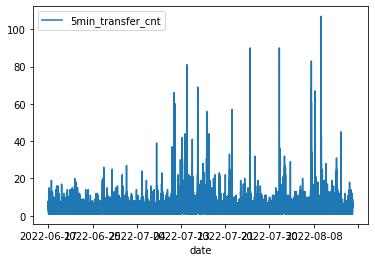

In [68]:
transfers_cnt_5min = transfers.groupby(
    ['date', 'hour', '5min']).count().reset_index()
transfers_cnt_5min.rename(
    columns = {'price_in_eth':'5min_transfer_cnt'}, inplace = True)
transfers_cnt_5min = transfers_cnt_5min[
    ['date', '5min_transfer_cnt']]
transfers_cnt_5min.plot(x='date', y='5min_transfer_cnt')

In [69]:
transfers_cnt_5min.describe()

,5min_transfer_cnt
count,17211.000000
mean,4.839521
std,5.073434
min,1.000000
25%,2.000000
50%,4.000000
75%,6.000000
max,107.000000


###### 10min Transfer Stats

In [70]:
transfers['10min'] = transfers.apply(
    lambda x: int(math.ceil(pd.to_datetime(x['timestamp']).minute / 10)),
    axis=1)
transfers_cnt_10min = transfers.groupby(
    ['date', 'hour', '10min']).count().reset_index()
transfers_cnt_10min.rename(
    columns = {'price_in_eth':'10min_transfer_cnt'}, inplace = True)
transfers_cnt_10min = transfers_cnt_10min[
    ['date', '10min_transfer_cnt']]
transfers_cnt_10min.describe()

,10min_transfer_cnt
count,9340.000000
mean,8.917880
std,9.241174
min,1.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,198.000000


<AxesSubplot:xlabel='date'>

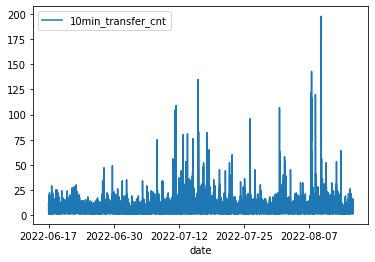

In [71]:
transfers_cnt_10min.plot(x='date', y='10min_transfer_cnt')

##### Hourly Transfer Stats

In [72]:
transfers_cnt_hourly = transfers.groupby(
    ['date', 'hour']).count().reset_index()
transfers_cnt_hourly.rename(
    columns = {'price_in_eth':'hourly_transfer_cnt'}, inplace = True)
transfers_cnt_hourly = transfers_cnt_hourly[
    ['date', 'hourly_transfer_cnt']]
transfers_cnt_hourly.describe()

,hourly_transfer_cnt
count,1440.000000
mean,57.842361
std,46.961898
min,14.000000
25%,36.000000
50%,48.000000
75%,65.000000
max,736.000000


<AxesSubplot:xlabel='date'>

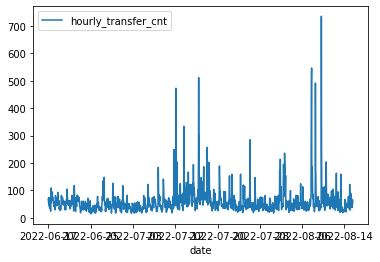

In [73]:
transfers_cnt_hourly.plot(x='date', y='hourly_transfer_cnt')

##### Daily Transfer Stats

In [74]:
transfers_cnt_daily = transfers.groupby(
    ['date']).count().reset_index()
transfers_cnt_daily.rename(
    columns = {'price_in_eth':'daily_transfer_cnt'}, inplace = True)
transfers_cnt_daily = transfers_cnt_daily[
    ['date', 'daily_transfer_cnt']]
transfers_cnt_daily.describe()

,daily_transfer_cnt
count,60.000000
mean,1388.216667
std,451.427720
min,742.000000
25%,1097.250000
50%,1272.000000
75%,1503.500000
max,2515.000000


<AxesSubplot:xlabel='date'>

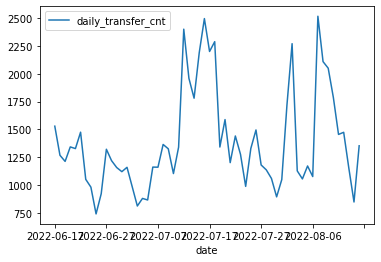

In [75]:
transfers_cnt_daily.plot(x='date', y='daily_transfer_cnt')

# Event Ranking
1. For the first version, we only focus on daily transfers
2. For the daily transfers, the avg is 1388 while max is 2515
3. The problem for event ranking is then narrowed to rank these events
4. Later, we can think of how to carry over historical event to today's
5. In production, we should add 5 mins or 10 mins events to the daily event queue before ranking. That is, the ranking logic is run every 5 or 10 mins
6. This would require the daily feeds being updated every 5 or 10 mins

### Get One Day Events

In [95]:
%%time
transfers = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/tagged_events.csv')

CPU times: user 3min 10s, sys: 1min 18s, total: 4min 28s
Wall time: 7min 4s


In [97]:
%%time
# one day data for ranking
cur_dt = '2022-08-14'
daily_events = transfers[transfers['date'] == cur_dt]
import pandas as pd
daily_events.to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/daily_events=2022-08-14.csv')

CPU times: user 6.83 s, sys: 449 ms, total: 7.28 s
Wall time: 8.65 s


In [105]:
# release memory
df_to_delete = [transfers]
del df_to_delete

### Filter by Top Collections

In [98]:
%%time
import pandas as pd
daily_events = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/daily_events=2022-08-14.csv')

CPU times: user 1.52 s, sys: 258 ms, total: 1.78 s
Wall time: 2.14 s


In [99]:
daily_events = daily_events[[
    'transaction_hash', 'timestamp', 'date', 'collection_id',
    'nft_id', 'buyer', 'price_in_eth', 'type']]

In [100]:
top_collections = {'0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb': 146,
 '0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d': 139,
 '0x60e4d786628fea6478f785a6d7e704777c86a7c6': 133,
 '0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7': 111,
 '0xba30e5f9bb24caa003e9f2f0497ad287fdf95623': 108,
 '0x49cf6f5d44e70224e2e23fdcdd2c053f30ada28b': 92,
 '0x8a90cab2b38dba80c64b7734e58ee1db38b8992e': 92,
 '0xed5af388653567af2f388e6224dc7c4b3241c544': 88,
 '0x42069abfe407c60cf4ae4112bedead391dba1cdb': 77,
 '0x059edd72cd353df5106d2b9cc5ab83a52287ac3a': 73,
 '0x1a92f7381b9f03921564a437210bb9396471050c': 73,
 '0x282bdd42f4eb70e7a9d9f40c8fea0825b7f68c5d': 70,
 '0x7d8820fa92eb1584636f4f5b8515b5476b75171a': 69,
 '0x5cc5b05a8a13e3fbdb0bb9fccd98d38e50f90c38': 58,
 '0x0a36f2178c0db2c85471c45334a1dd17d130fd42': 58,
 '0xaadc2d4261199ce24a4b0a57370c4fcf43bb60aa': 56,
 '0x79fcdef22feed20eddacbb2587640e45491b757f': 54,
 '0xccc441ac31f02cd96c153db6fd5fe0a2f4e6a68d': 53,
 '0xbc578ecca2115dac0c93c08674edc0c7d01fe09c': 50,
 '0x82c7a8f707110f5fbb16184a5933e9f78a34c6ab': 49,
 '0xd4e4078ca3495de5b1d4db434bebc5a986197782': 49,
 '0x509a050f573be0d5e01a73c3726e17161729558b': 48,
 '0x23581767a106ae21c074b2276d25e5c3e136a68b': 47,
 '0xa7d8d9ef8d8ce8992df33d8b8cf4aebabd5bd270': 47,
 '0x08d7c0242953446436f34b4c78fe9da38c73668d': 46,
 '0x59468516a8259058bad1ca5f8f4bff190d30e066': 44,
 '0xd1258db6ac08eb0e625b75b371c023da478e94a9': 43,
 '0xe8f88d16f24255fcfab25959705d724406d67d9d': 43,
 '0x6ffa9756ded18df772f18754c98c81b6fe76431d': 42,
 '0xc143bbfcdbdbed6d454803804752a064a622c1f3': 41,
 '0x2c3fc1d826bc12027d05fbe3aeace0a2453bf9fd': 41,
 '0x46ac8540d698167fcbb9e846511beb8cf8af9bd8': 41,
 '0x2a036569dbbe7730d69ed664b74412e49f43c2c0': 40,
 '0xff36ca1396d2a9016869274f1017d6c2139f495e': 40,
 '0x85885aded016ba8a88593338928c88d99316ace9': 40,
 '0xd45ea3d9426595f32a4b87f0225022d8d179526c': 39,
 '0x64ad353bc90a04361c4810ae7b3701f3beb48d7e': 38,
 '0x3273ae3fff2f5f83b899181d617c8bbd870f9b24': 38,
 '0xccf3baa603dfddd7c41619fdb8dd0306b11571fe': 37,
 '0xbd3531da5cf5857e7cfaa92426877b022e612cf8': 36,
 '0xe785e82358879f061bc3dcac6f0444462d4b5330': 36,
 '0x892848074ddea461a15f337250da3ce55580ca85': 36,
 '0xb7f7f6c52f2e2fdb1963eab30438024864c313f6': 36,
 '0x0c06601b50aa10dcdb9434e627f5f12c971301ff': 35,
 '0xb932a70a57673d89f4acffbe830e8ed7f75fb9e0': 34,
 '0xd2a077ec359d94e0a0b7e84435eacb40a67a817c': 34,
 '0x0cfb5d82be2b949e8fa73a656df91821e2ad99fd': 32,
 '0xe0176ba60efddb29cac5b15338c9962daee9de0c': 32,
 '0x80336ad7a747236ef41f47ed2c7641828a480baa': 31,
 '0x63f421b24cea6765b326753f6d4e558c21ea8f76': 31,
 '0x32d813d74836f2054a8820560a8b5604a2697360': 31,
 '0x27787755137863bb7f2387ed34942543c9f24efe': 30,
 '0xf07468ead8cf26c752c676e43c814fee9c8cf402': 30,
 '0xbd4455da5929d5639ee098abfaa3241e9ae111af': 29,
 '0x0b4b2ba334f476c8f41bfe52a428d6891755554d': 29,
 '0x1ccf997a9a93548e3b9dcdab159894fc0a80100a': 29,
 '0xc99c679c50033bbc5321eb88752e89a93e9e83c5': 28,
 '0x6fefb647395e680339badc84dc774e3ca8bca7b9': 28,
 '0x306b1ea3ecdf94ab739f1910bbda052ed4a9f949': 27,
 '0xe47e5dcde8e14e874d2711e786bb34ae6980bef8': 27,
 '0x4866f5e34ae43987b93a929152eb3b95902bb0ca': 26,
 '0xa3aee8bce55beea1951ef834b99f3ac60d1abeeb': 25,
 '0x364c828ee171616a39897688a831c2499ad972ec': 25,
 '0xeaa4c58427c184413b04db47889b28b5c98ebb7b': 25,
 '0x46fdfcb3cd89a1c54d36ee83a4adc184747b40d9': 24,
 '0x5b5cf41d9ec08d101ffeeeebda411677582c9448': 24,
 '0x438295b5082dc6a0cc50960e3513d5d7f23405c4': 23,
 '0x75e95ba5997eb235f40ecf8347cdb11f18ff640b': 22,
 '0x249aeaa7fa06a63ea5389b72217476db881294df': 22,
 '0x0b0585e9cf470c59b15914586fa54ed7a4467e3c': 22,
 '0xf729f878f95548bc7f14b127c96089cf121505f8': 21,
 '0xa5e97633d5626568fb1f45c45f2a4f3b793b264d': 21,
 '0x3d978e0b4fc54b419c4281320d7384a2ff93421f': 20,
 '0x3fd36d72f05fb1af76ee7ce9257ca850faba91ed': 19,
 '0xd0e7bc3f1efc5f098534bce73589835b8273b9a0': 19,
 '0x26badf693f2b103b021c670c852262b379bbbe8a': 18,
 '0x4a537f61ef574153664c0dbc8c8f4b900cacbe5d': 18,
 '0xd1169e5349d1cb9941f3dcba135c8a4b9eacfdde': 17,
 '0xe1af29ff354eb041a3c08ce9362d65e8364df5c1': 17,
 '0xc1c7fb277d9c75df7cd03327a1b39aadbfb545a3': 16,
 '0x3110ef5f612208724ca51f5761a69081809f03b7': 15,
 '0x123b30e25973fecd8354dd5f41cc45a3065ef88c': 15,
 '0xe0d1fa3fbd72db2ed179f80c0459b7da93fe4fe8': 14,
 '0xd0b67acc0e5918192b158c1647dad5782e6f4fb5': 14,
 '0x19b86299c21505cdf59ce63740b240a9c822b5e4': 13,
 '0x9b091d2e0bb88ace4fe8f0fab87b93d8ba932ec4': 13,
 '0x1fbfea2506ee4234d0dbf22b2b5a359068b58c43': 13,
 '0x36f4d96fe0d4eb33cdc2dc6c0bca15b9cdd0d648': 12,
 '0x09233d553058c2f42ba751c87816a8e9fae7ef10': 12,
 '0xacab8aa12b92afb6adcb598dc16f4e09b3fee732': 12,
 '0x3acdb27a3c9673338b27a31ca17f2fb76b79ef92': 11,
 '0x3702f4c46785bbd947d59a2516ac1ea30f2babf2': 10,
 '0xbf45d42c7ff2c5c148863ce65e492657e7c6d926': 10,
 '0x5af0d9827e0c53e4799bb226655a1de152a425a5': 9,
 '0x7ea3cca10668b8346aec0bf1844a49e995527c8b': 9,
 '0x250ff17091c3c8beddc32c6ce66f2e896c07acb7': 9,
 '0x3e7fc44e25c07be3d67c241e6e59cb838df2f892': 8,
 '0x4db1f25d3d98600140dfc18deb7515be5bd293af': 8,
 '0x32973908faee0bf825a343000fe412ebe56f802a': 8,
 '0x484e5155ae4b277cdb7f13a80ab3f627ff491149': 8,
 '0x8eaa9ae1ac89b1c8c8a8104d08c045f78aadb42d': 7,
 '0xd0318da435dbce0b347cc6faa330b5a9889e3585': 7,
 '0x3f95f48b99f864913f697ef6c45dbcde1beef2ae': 7,
 '0x2a48420d75777af4c99970c0ed3c25effd1c08be': 6,
 '0x64780ce53f6e966e18a22af13a2f97369580ec11': 6,
 '0xba72b008d53d3e65f6641e1d63376be2f9c1ad05': 5,
 '0x33eecbf908478c10614626a9d304bfe18b78dd73': 5,
 '0x11ca9693156929ee2e7e1470c5e1a55b413e9007': 4,
 '0x8a939fd297fab7388d6e6c634eee3c863626be57': 4,
 '0xf59afe732b2793d541780fd02945228db1fad8ed': 3,
 '0x6fc3ad6177b07227647ad6b4ae03cc476541a2a0': 3,
 '0x2cf6be9aac1c7630d5a23af88c28275c70eb8819': 2,
 '0xe37aa7c85a763da1c6d58285a465c2e5da84471b': 2,
 '0xc67b9897d793a823f0e9cf850aa1b0d23e3f8d09': 1,
 '0x11450058d796b02eb53e65374be59cff65d3fe7f': 1,
 '0x944a883089beb14754601d11ff9d02862d607c5c': 1}
top_collections_set = set(top_collections.keys())

In [101]:
top_collections_set

{'0x059edd72cd353df5106d2b9cc5ab83a52287ac3a',
 '0x08d7c0242953446436f34b4c78fe9da38c73668d',
 '0x09233d553058c2f42ba751c87816a8e9fae7ef10',
 '0x0a36f2178c0db2c85471c45334a1dd17d130fd42',
 '0x0b0585e9cf470c59b15914586fa54ed7a4467e3c',
 '0x0b4b2ba334f476c8f41bfe52a428d6891755554d',
 '0x0c06601b50aa10dcdb9434e627f5f12c971301ff',
 '0x0cfb5d82be2b949e8fa73a656df91821e2ad99fd',
 '0x11450058d796b02eb53e65374be59cff65d3fe7f',
 '0x11ca9693156929ee2e7e1470c5e1a55b413e9007',
 '0x123b30e25973fecd8354dd5f41cc45a3065ef88c',
 '0x19b86299c21505cdf59ce63740b240a9c822b5e4',
 '0x1a92f7381b9f03921564a437210bb9396471050c',
 '0x1ccf997a9a93548e3b9dcdab159894fc0a80100a',
 '0x1fbfea2506ee4234d0dbf22b2b5a359068b58c43',
 '0x23581767a106ae21c074b2276d25e5c3e136a68b',
 '0x249aeaa7fa06a63ea5389b72217476db881294df',
 '0x250ff17091c3c8beddc32c6ce66f2e896c07acb7',
 '0x26badf693f2b103b021c670c852262b379bbbe8a',
 '0x27787755137863bb7f2387ed34942543c9f24efe',
 '0x282bdd42f4eb70e7a9d9f40c8fea0825b7f68c5d',
 '0x2a036569d

In [102]:
daily_events = daily_events[daily_events.collection_id.isin(
    top_collections_set)]

In [103]:
len(daily_events)

3864

In [104]:
collection_rank = pd.DataFrame(
    top_collections.items(),
    columns=['collection_id', 'rank'])[['collection_id', 'rank']]
collection_rank.head()

,collection_id,rank
0,0xb47e3cd837ddf8e4c57f05d70ab865de6e193bbb,146
1,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,139
2,0x60e4d786628fea6478f785a6d7e704777c86a7c6,133
3,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7,111
4,0xba30e5f9bb24caa003e9f2f0497ad287fdf95623,108


In [106]:
daily_events = pd.merge(daily_events,
                        collection_rank,
                        on='collection_id',
                        how='outer')

In [107]:
len(daily_events)

3889

In [109]:
daily_events.head()

,transaction_hash,timestamp,date,collection_id,nft_id,buyer,price_in_eth,type,rank
0,0xa73c7548812c217a8dc590f3ac8e19e51453492f6f068f080a2648a47394f7ed,2022-08-14 23:59:51+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/1987,0x559235e6c3692698df15d5dd3503fbdbb472a43b,1.1,purchase,31
1,0xec277983f6354a13b7bfe7ed53070d1269d96a202784f482581f9af382d8a739,2022-08-14 23:32:26+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/2023,0x38e6f80e29d2f0ebf68e5ea8e177723cbf77dc87,0.0,invalid,31
2,0x9247381f85ad1da05529018f23c76d37163aa0055ec9b75205c191f5ea0194a0,2022-08-14 22:29:01+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/1987,0xea04309d1d95b994a4f4efe77ef73fd4e79d8f11,0.0,invalid,31
3,0xba30294100dd2892f3421cbfef51480302e982bbc65ef195ab3b130a48ee9c23,2022-08-14 21:39:46+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/1967,0xa40829b32748b8d6013e7a1a57e5e0d390407acd,0.0,invalid,31
4,0xa4ce7885627fc3e48394501b09643e34b27561f025252609c309528ead476efb,2022-08-14 21:27:46+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/2141,0x30029eb13ba3be4296f63f188420386954bd0f91,0.0,invalid,31


In [108]:
%%time
import pandas as pd
daily_events.to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/daily_events_with_rank=2022-08-14.csv')

CPU times: user 34.7 ms, sys: 37.1 ms, total: 71.8 ms
Wall time: 71.9 ms


### Rank Mints, Burns and Purchases
- Todo: 
    - For personalization, include comment, like, and click factors into each ranking algorithm

In [166]:
%%time
import pandas as pd
daily_events = pd.read_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/daily_events_with_rank=2022-08-14.csv')

CPU times: user 21.6 ms, sys: 15.6 ms, total: 37.3 ms
Wall time: 40 ms


In [167]:
daily_events.head()

,Unnamed: 0,transaction_hash,timestamp,date,collection_id,nft_id,buyer,price_in_eth,type,rank
0,0,0xa73c7548812c217a8dc590f3ac8e19e51453492f6f068f080a2648a47394f7ed,2022-08-14 23:59:51+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/1987,0x559235e6c3692698df15d5dd3503fbdbb472a43b,1.1,purchase,31
1,1,0xec277983f6354a13b7bfe7ed53070d1269d96a202784f482581f9af382d8a739,2022-08-14 23:32:26+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/2023,0x38e6f80e29d2f0ebf68e5ea8e177723cbf77dc87,0.0,invalid,31
2,2,0x9247381f85ad1da05529018f23c76d37163aa0055ec9b75205c191f5ea0194a0,2022-08-14 22:29:01+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/1987,0xea04309d1d95b994a4f4efe77ef73fd4e79d8f11,0.0,invalid,31
3,3,0xba30294100dd2892f3421cbfef51480302e982bbc65ef195ab3b130a48ee9c23,2022-08-14 21:39:46+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/1967,0xa40829b32748b8d6013e7a1a57e5e0d390407acd,0.0,invalid,31
4,4,0xa4ce7885627fc3e48394501b09643e34b27561f025252609c309528ead476efb,2022-08-14 21:27:46+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/2141,0x30029eb13ba3be4296f63f188420386954bd0f91,0.0,invalid,31


In [168]:
daily_events = daily_events[daily_events['date'].notnull()]
types_to_rank = set(['purchase', 'mint', 'burn'])
daily_events = daily_events[daily_events['type'].isin(types_to_rank)]
print(len(daily_events[daily_events['type'] == 'invalid']))
print(len(daily_events[daily_events['type'] == 'non721']))
print(len(daily_events[daily_events['type'] == 'mint']))
print(len(daily_events[daily_events['type'] == 'purchase']))
print(len(daily_events[daily_events['type'] == 'burn']))

0
0
675
1032
8


In [169]:
%%time
import pandas as pd
import math
daily_events['hour'] = daily_events.apply(
    lambda x: int(pd.to_datetime(x['timestamp']).hour),
    axis=1)
daily_events['5min'] = daily_events.apply(
    lambda x: int(math.ceil(pd.to_datetime(x['timestamp']).minute / 5)),
    axis=1)
daily_events.sort_values(by=['timestamp'], ascending=False, inplace=True)

CPU times: user 155 ms, sys: 5.24 ms, total: 160 ms
Wall time: 158 ms


In [170]:
daily_events['type'].unique()

array(['purchase', 'mint', 'burn'], dtype=object)

In [171]:
daily_events.head()

,Unnamed: 0,transaction_hash,timestamp,date,collection_id,nft_id,buyer,price_in_eth,type,rank,hour,5min
0,0,0xa73c7548812c217a8dc590f3ac8e19e51453492f6f068f080a2648a47394f7ed,2022-08-14 23:59:51+00:00,2022-08-14,0x80336ad7a747236ef41f47ed2c7641828a480baa,0x80336ad7a747236ef41f47ed2c7641828a480baa/1987,0x559235e6c3692698df15d5dd3503fbdbb472a43b,1.1000,purchase,31,23,12
167,167,0xd20a8a44e4c707ae4e55fb713bd9556b435967293e0aac1e1b79439c1b18597f,2022-08-14 23:58:15+00:00,2022-08-14,0x249aeaa7fa06a63ea5389b72217476db881294df,0x249aeaa7fa06a63ea5389b72217476db881294df/4640,0x5f6ae73426c63358ba0e69c445be1211e7da405f,0.1200,purchase,22,23,12
255,255,0x9e183c8631256d64770053cc5aa2bff9898538a9c76e4ade7b57fdd64ba12c63,2022-08-14 23:57:31+00:00,2022-08-14,0xc99c679c50033bbc5321eb88752e89a93e9e83c5,0xc99c679c50033bbc5321eb88752e89a93e9e83c5/1330,0x2a138e24cf857f189826600463c05d0cac5aeede,0.8780,purchase,28,23,12
296,296,0xce1c1b0c13ffd65823d63e9cb2bb747a64725c7e730cc6019a118eec0910b006,2022-08-14 23:57:18+00:00,2022-08-14,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/8117,0x89669dac0fa49b471528711a26ff250836d0f6c1,5.1100,purchase,111,23,12
380,380,0xdc18b09febf2ed3bd18e9b48bc96e77ccce3bd9c1c0276ac1843265f36f1ebfd,2022-08-14 23:55:52+00:00,2022-08-14,0x2a48420d75777af4c99970c0ed3c25effd1c08be,0x2a48420d75777af4c99970c0ed3c25effd1c08be/4887,0x3062b12ff6a74c961faee546fd152161b81a53fb,0.3228,purchase,6,23,11


In [172]:
def update_rank(cur_5min,
                     cur_hour,
                     cur_date,
                     diversity_cnt,
                     event):
    rank = event['rank']
    
    # rerank by recency
    if event['hour'] == cur_hour and event['date'] == cur_date:
        # same hour: add rank by 25
        # i.e collection rank + 25
        rank += 25
        # same 5min interval: add rank by another 25
        # i.e collection rank + 50
        if event['5min'] == cur_5min:
            rank += 25
    else:
        if event['date'] != cur_date:
            hours_passed_by = 24 - event['hour'] + cur_hour
        else:
            hours_passed_by = cur_hour - event['hour']
        rank += 24 - hours_passed_by
        
    # rerank for diversity
    collection = event['collection_id']
    if diversity_cnt[collection] <= 3:
        rank -= diversity_cnt[collection] * 10
    elif diversity_cnt[collection] <= 6:
        rank -= diversity_cnt[collection] * 20
    else:
        rank -= diversity_cnt[collection] * 30
        
    # Add personalization in production:
    # rank += 30 if purchased before
    if event['type'] == 'mint':
        rank += 20
    elif event['type'] == 'burn':
        rank += 10
        
    diversity_cnt[collection] += 1

    return rank

In [173]:
from collections import defaultdict

cur_5min = 11
cur_hour = 23
diversity_cnt = defaultdict(int)
daily_events['rank'] = daily_events.apply(
    lambda event: update_rank(
        cur_5min, cur_hour, cur_dt, diversity_cnt, event), axis=1)

In [174]:
daily_events.sort_values(by=['rank'], ascending=False, inplace=True)

In [175]:
pd.set_option('display.max_colwidth', None)
daily_events.head()

,Unnamed: 0,transaction_hash,timestamp,date,collection_id,nft_id,buyer,price_in_eth,type,rank,hour,5min
80,80,0xedd7cc1337825f5cce8f38143b192366d621f1f3c762b599655835aa8a5df4ff,2022-08-14 21:51:19+00:00,2022-08-14,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/609,0x56441b79ebcb24c9a80221dad65c3ddfc7d39c17,0.005000,purchase,161,21,11
2571,2571,0xf8ffddeac2f01bca61d34c1d21ba64814d861fe502c8e370f837abf28e50b9ee,2022-08-14 23:19:54+00:00,2022-08-14,0x60e4d786628fea6478f785a6d7e704777c86a7c6,0x60e4d786628fea6478f785a6d7e704777c86a7c6/19210,0x3cf3303e38b8b4081689e1f590e76e482bff1139,14.850000,purchase,158,23,4
81,81,0x165256c32edcf0a248cfc62f16163de77ffd71e838180dd6055aa76ab2ee08c9,2022-08-14 21:42:52+00:00,2022-08-14,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/7644,0x19fffb371b95574df860e90b6a5b69256629b585,7.080397,purchase,151,21,9
2572,2572,0x7712d60c8f08bac83ac0da2adc323f1014d75447d0cae54c63f59c1106b3fcb7,2022-08-14 22:35:13+00:00,2022-08-14,0x60e4d786628fea6478f785a6d7e704777c86a7c6,0x60e4d786628fea6478f785a6d7e704777c86a7c6/4977,0x42f61c5f5504807b18e9ba30a6535848627b7a5b,14.490000,purchase,146,22,7
296,296,0xce1c1b0c13ffd65823d63e9cb2bb747a64725c7e730cc6019a118eec0910b006,2022-08-14 23:57:18+00:00,2022-08-14,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/8117,0x89669dac0fa49b471528711a26ff250836d0f6c1,5.110000,purchase,136,23,12


In [176]:
daily_events.drop(['date', 'hour', '5min'], axis=1)

,Unnamed: 0,transaction_hash,timestamp,collection_id,nft_id,buyer,price_in_eth,type,rank
80,80,0xedd7cc1337825f5cce8f38143b192366d621f1f3c762b599655835aa8a5df4ff,2022-08-14 21:51:19+00:00,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/609,0x56441b79ebcb24c9a80221dad65c3ddfc7d39c17,0.005000,purchase,161
2571,2571,0xf8ffddeac2f01bca61d34c1d21ba64814d861fe502c8e370f837abf28e50b9ee,2022-08-14 23:19:54+00:00,0x60e4d786628fea6478f785a6d7e704777c86a7c6,0x60e4d786628fea6478f785a6d7e704777c86a7c6/19210,0x3cf3303e38b8b4081689e1f590e76e482bff1139,14.850000,purchase,158
81,81,0x165256c32edcf0a248cfc62f16163de77ffd71e838180dd6055aa76ab2ee08c9,2022-08-14 21:42:52+00:00,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d,0xbc4ca0eda7647a8ab7c2061c2e118a18a936f13d/7644,0x19fffb371b95574df860e90b6a5b69256629b585,7.080397,purchase,151
2572,2572,0x7712d60c8f08bac83ac0da2adc323f1014d75447d0cae54c63f59c1106b3fcb7,2022-08-14 22:35:13+00:00,0x60e4d786628fea6478f785a6d7e704777c86a7c6,0x60e4d786628fea6478f785a6d7e704777c86a7c6/4977,0x42f61c5f5504807b18e9ba30a6535848627b7a5b,14.490000,purchase,146
296,296,0xce1c1b0c13ffd65823d63e9cb2bb747a64725c7e730cc6019a118eec0910b006,2022-08-14 23:57:18+00:00,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7,0x7bd29408f11d2bfc23c34f18275bbf23bb716bc7/8117,0x89669dac0fa49b471528711a26ff250836d0f6c1,5.110000,purchase,136
...,...,...,...,...,...,...,...,...,...
1927,1927,0xca3ce7df1f18ae8485044e42a09db9de87daaf9829e6424c45bc6f73e8006387,2022-08-14 01:25:55+00:00,0x63f421b24cea6765b326753f6d4e558c21ea8f76,0x63f421b24cea6765b326753f6d4e558c21ea8f76/4812,0xc915d5d72bf08d71ad9249cedb4acf29db022232,0.000000,mint,-16477
1929,1929,0xa045916f5f8dc8e31cedaf1421969ea0b81cc1fe69415c65d0dfa1b74551e3aa,2022-08-14 01:24:00+00:00,0x63f421b24cea6765b326753f6d4e558c21ea8f76,0x63f421b24cea6765b326753f6d4e558c21ea8f76/4810,0x70b684bda9e1e15bfe6115521ab08c15347ea2ee,0.000000,mint,-16507
1931,1931,0xc9a735049a5e8a9cfb18b8410ea51bd0e55eeb4b0054f06ee83a0c6ddf8fa7f3,2022-08-14 00:37:37+00:00,0x63f421b24cea6765b326753f6d4e558c21ea8f76,0x63f421b24cea6765b326753f6d4e558c21ea8f76/4808,0xaad21a4e83708284dd1127ea7415ab13c571fd40,0.000000,mint,-16538
1930,1930,0xc9a735049a5e8a9cfb18b8410ea51bd0e55eeb4b0054f06ee83a0c6ddf8fa7f3,2022-08-14 00:37:37+00:00,0x63f421b24cea6765b326753f6d4e558c21ea8f76,0x63f421b24cea6765b326753f6d4e558c21ea8f76/4809,0xaad21a4e83708284dd1127ea7415ab13c571fd40,0.000000,mint,-16568


In [177]:
daily_events.to_csv(
    '/Users/xin/coding/nft-recommendation/data_analysis/data/ranked_nft_events.csv')